# Project Overview

<b>Competition Description from Kaggle:</b>

Think back to your favorite teacher. They motivated and inspired you to learn. And they knew your strengths and weaknesses. The lessons they taught were based on your ability. For example, teachers would make sure you understood algebra before advancing to calculus. Yet, many students don’t have access to personalized learning. In a world full of information, data scientists like you can help. Machine learning can offer a path to success for young people around the world, and you are invited to be part of this mission.



In 2018, 260 million children weren't attending school. At the same time, more than half of these young students didn't meet minimum reading and math standards. Education was already in a tough place when COVID-19 forced most countries to temporarily close schools. This further delayed learning opportunities and intellectual development. The equity gaps in every country could grow wider. We need to re-think the current education system in terms of attendance, engagement, and individualized attention.

Riiid Labs, an AI solutions provider delivering creative disruption to the education market, empowers global education players to rethink traditional ways of learning leveraging AI. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions.

In this competition, your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data.

Your innovative algorithms will help tackle global challenges in education. If successful, it’s possible that any student with an Internet connection can enjoy the benefits of a personalized learning experience, regardless of where they live. With your participation, we can build a better and more equitable model for education in a post-COVID-19 world.

<b>Elevator Pitch</b>

The goal of this project is to predict how students will perform on future interactions with an AI tutor developed at Riiid Labs. AI solutions can change the current education system in terms of attendance, engagement, and individualized attention. It's especially relevant now in times of COVID as many schools have shutdown and switched to remote learning. If successful, AI could provide more equal opportunity in education to anyone with an internet connection. My model should help predict and guide the success of the AI tutor. I will be doing analytics on past student performance and predict if the student will get future questions right, wrong, or leave it blank.

8 features
- timestamp                         int64
- user_id                           int64
- content_id                        int64
- content_type_id                   int64
- task_container_id                 int64
- user_answer                       int64
- prior_question_elapsed_time       float64
- prior_question_had_explanation    object

1 target
- answered_correctly                int64
- -1(did not answer), 0 (answered incorrectly), 1(answered correctly)

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso, Ridge, LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from dask.distributed import Client, LocalCluster
import joblib

In [2]:
cluster = LocalCluster()
client = Client(cluster) # start a local Dask client

In [3]:
cluster

# Data

#### Download Data

In [4]:
# Download the competition data from kaggle
# ! kaggle competitions download -c riiid-test-answer-prediction -p ../../data

In [5]:
# Unzip the data
# with zipfile.ZipFile('../../data/riiid-test-answer-prediction.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data')

#### Import Data

In [6]:
# Import the data as Pandas DataFrames
train = pd.read_csv('../../data/train.csv')
questions = pd.read_csv('../../data/questions.csv')
lectures = pd.read_csv('../../data/lectures.csv')

#### Explore Data

In [7]:
train.shape
# 101,230,332 rows

(101230332, 10)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
row_id                            int64
timestamp                         int64
user_id                           int64
content_id                        int64
content_type_id                   int64
task_container_id                 int64
user_answer                       int64
answered_correctly                int64
prior_question_elapsed_time       float64
prior_question_had_explanation    object
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [9]:
train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


In [10]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [11]:
# Getting a 100k sample of my data to work with cause mo data mo problems
train_sample = train.sample(n=100000, random_state=42)

In [12]:
# Split data into features and target
X = train_sample.drop('answered_correctly', axis=1)
y = train_sample['answered_correctly']

Text(0.5, 1.0, 'Class distribution')

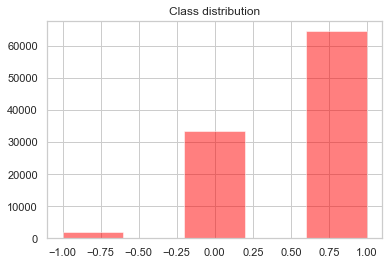

In [13]:
# Class Imbalance
sns.set(context = 'notebook', style = 'whitegrid')
fig, ax = plt.subplots(figsize = (6,4)) 
ax.hist(y, color = 'red', alpha = .5, bins = 5)
ax.set_title('Class distribution')

### Prepare data for modeling

In [14]:
# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [15]:
# Pipeline for preprocessing numeric features
numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
categorical_features = list(X.select_dtypes(include='object').columns)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value=False)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [16]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Modeling

#### First Simple Model

In [17]:
# Logistic Regression Model Fit
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

In [18]:
# Score on our training data
y_pred = fsm.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1367
           0       0.59      0.04      0.07     23400
           1       0.66      0.99      0.79     45233

    accuracy                           0.67     70000
   macro avg       0.75      0.67      0.62     70000
weighted avg       0.65      0.67      0.56     70000



In [19]:
# Score on our testing data
y_pred = fsm.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.56      0.03      0.06     10055
           1       0.66      0.99      0.79     19379

    accuracy                           0.67     30000
   macro avg       0.74      0.67      0.62     30000
weighted avg       0.64      0.67      0.55     30000



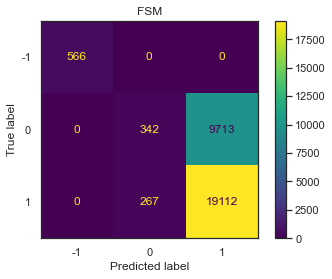

In [20]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(fsm, X_test_transformed, y_test)
plt.title('FSM');

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [21]:
print("Before OverSampling, counts of label -1: {}".format(sum(y_train == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 1: {} \n".format(sum(y_train == 1))) 

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label -1: {}".format(sum(y_train_res == -1))) 
print("After OverSampling, counts of label 0".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label 1: {}".format(sum(y_train_res == 1)))

Before OverSampling, counts of label -1: 1367
Before OverSampling, counts of label 0: 23400
Before OverSampling, counts of label 1: 45233 

After OverSampling, the shape of train_X: (135699, 11)
After OverSampling, the shape of train_y: (135699,) 

After OverSampling, counts of label -1: 45233
After OverSampling, counts of label 0
After OverSampling, counts of label 1: 45233


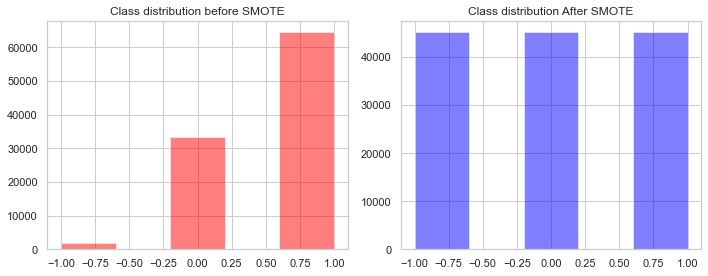

In [22]:
sns.set(context = 'notebook', style = 'whitegrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

#### Simple Linear Regression Model After Smote

In [23]:
# X_train_res, y_train_res, X_test_transformed, y_test
simple_lr = LogisticRegression()
with joblib.parallel_backend('dask'):
    simple_lr.fit(X_train_res, y_train_res)

In [24]:
# Score on our training data
y_pred = simple_lr.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.55      0.36      0.44     45233
           1       0.53      0.71      0.60     45233

    accuracy                           0.69    135699
   macro avg       0.69      0.69      0.68    135699
weighted avg       0.69      0.69      0.68    135699



In [25]:
# Score on testing data
y_pred = simple_lr.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.38      0.36      0.37     10055
           1       0.68      0.70      0.69     19379

    accuracy                           0.59     30000
   macro avg       0.69      0.69      0.69     30000
weighted avg       0.59      0.59      0.59     30000



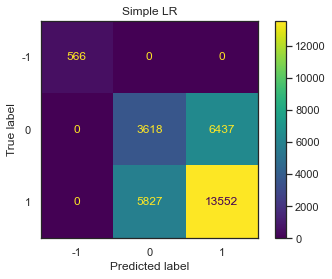

In [26]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(simple_lr, X_test_transformed, y_test)
plt.title('Simple LR');

In [27]:
# # Grid Search for best params for Logistic Regression Classifier
# params = {
#     'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
#     'solver':['liblinear', 'saga'],
#     'C': [.0001, .001,.1, 1, 10],
#     'verbose': [0, 1],
#     'max_iter': [10, 100, 1000],
#     'tol': [1, 10, 100, 1000]
# }
# lr_gs = GridSearchCV(LogisticRegression(random_state=42), params, cv=3)
# with joblib.parallel_backend('dask'):
#     lr_gs.fit(X_train_res, y_train_res)

# print("Best Params", lr_gs.best_params_)
# print("Best Score", lr_gs.best_score_)
# # Best Params {'C': 0.001, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1, 'verbose': 0}
# # Best Score 0.6904251320938254

In [28]:
# Plug in best params and run model
lr_best = LogisticRegression(random_state=42, penalty= 'l2', solver= 'liblinear', C=.001, verbose=0, max_iter=10, tol=1)
lr_best.fit(X_train_res, y_train_res)

LogisticRegression(C=0.001, max_iter=10, random_state=42, solver='liblinear',
                   tol=1)

In [29]:
# Score on our training data
y_pred = lr_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.53      0.55      0.54     45233
           1       0.54      0.52      0.53     45233

    accuracy                           0.69    135699
   macro avg       0.69      0.69      0.69    135699
weighted avg       0.69      0.69      0.69    135699



In [30]:
# Score on testing data
y_pred = lr_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.37      0.54      0.44     10055
           1       0.68      0.52      0.59     19379

    accuracy                           0.54     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.58      0.54      0.55     30000



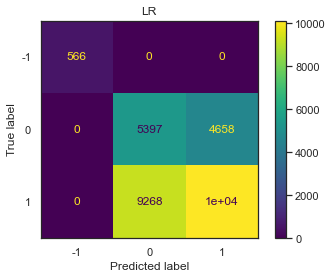

In [31]:
# Confusion matrix
plot_confusion_matrix(lr_best, X_test_transformed, y_test)
plt.title('LR');

#### K Nearest Neighbors

In [32]:
# # Grid Search for best params for KNN Classifier *Do this overnight, takes forever*
# params = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'p' : [1,2]
# }

# knn_gs = GridSearchCV(KNeighborsClassifier(), params)
# with joblib.parallel_backend('dask'):
#     knn_gs.fit(X_train_res, y_train_res)

# print("Best Params", knn_gs.best_params_)

In [33]:
# Plug in best params and run model
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [34]:
# Score on our training data
y_pred = knn_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.75      0.87      0.81     45233
           1       0.85      0.70      0.77     45233

    accuracy                           0.86    135699
   macro avg       0.87      0.86      0.86    135699
weighted avg       0.87      0.86      0.86    135699



In [35]:
# Score on testing data
y_pred = knn_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.36      0.49      0.42     10055
           1       0.68      0.56      0.61     19379

    accuracy                           0.54     30000
   macro avg       0.68      0.68      0.68     30000
weighted avg       0.58      0.54      0.55     30000



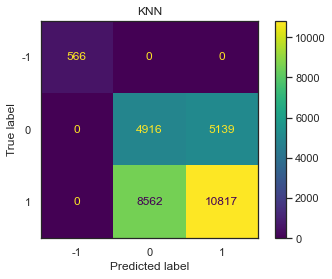

In [36]:
# Confusion matrix
plot_confusion_matrix(knn_best, X_test_transformed, y_test)
plt.title('KNN');

#### Random Forest

In [37]:
# # Grid Search for best params for Random Forest Classifier *Do this overnight, takes forever*
# params = {
#     'max_depth': [2, 4, 6],
#     'n_estimators': [100, 1000, 2000]
# }

# rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), params)
# with joblib.parallel_backend('dask'):
#     rf_gs.fit(X_train_res, y_train_res)

# print("Best Params", rf_gs.best_params_)

In [38]:
# Plug in best params and run model
rf_best = RandomForestClassifier(random_state=42)
rf_best.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [39]:
# Score on our training data
y_pred = rf_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       1.00      1.00      1.00     45233
           1       1.00      1.00      1.00     45233

    accuracy                           1.00    135699
   macro avg       1.00      1.00      1.00    135699
weighted avg       1.00      1.00      1.00    135699



In [40]:
# Score on testing data
y_pred = rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.43      0.39      0.41     10055
           1       0.70      0.73      0.72     19379

    accuracy                           0.62     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.62      0.62      0.62     30000



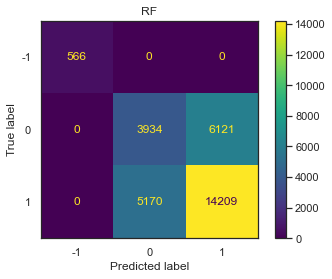

In [41]:
# Confusion matrix
plot_confusion_matrix(rf_best, X_test_transformed, y_test)
plt.title('RF');

#### Support Vector Machines

In [42]:
# Instantiate SVC
svc = SVC(cache_size=500, random_state=42)
with joblib.parallel_backend('dask'):
    svc.fit(X_train_res, y_train_res)

In [43]:
# Score on our training data
y_pred = svc.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.55      0.57      0.56     45233
           1       0.55      0.54      0.55     45233

    accuracy                           0.70    135699
   macro avg       0.70      0.70      0.70    135699
weighted avg       0.70      0.70      0.70    135699



In [44]:
# Score on testing data
y_pred = svc.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.39      0.57      0.46     10055
           1       0.70      0.54      0.61     19379

    accuracy                           0.55     30000
   macro avg       0.70      0.70      0.69     30000
weighted avg       0.60      0.55      0.57     30000



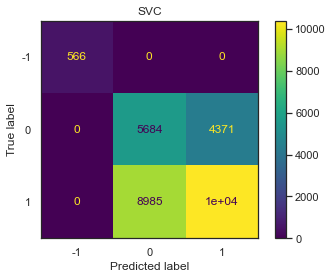

In [45]:
# Confusion matrix
plot_confusion_matrix(svc, X_test_transformed, y_test)
plt.title('SVC');

#### AdaBoost

In [46]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_res, y_train_res)

AdaBoostClassifier(random_state=42)

In [47]:
# Score on our training data
y_pred = adaboost.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.51      0.92      0.65     45233
           1       0.55      0.10      0.16     45233

    accuracy                           0.67    135699
   macro avg       0.69      0.67      0.61    135699
weighted avg       0.69      0.67      0.61    135699



In [48]:
# Score on testing data
y_pred = adaboost.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.34      0.92      0.50     10055
           1       0.69      0.09      0.17     19379

    accuracy                           0.39     30000
   macro avg       0.68      0.67      0.56     30000
weighted avg       0.58      0.39      0.29     30000



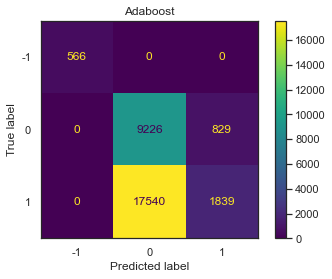

In [49]:
# Confusion matrix
plot_confusion_matrix(adaboost, X_test_transformed, y_test)
plt.title('Adaboost');

#### Extreme Gradient Boosting

In [50]:
# Instantiate XGBClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
# XGB Optomized for distributed computing. Parallel training.
xgb = XGBClassifier(max_depth=10, random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [51]:
# Score on our training data
y_pred = xgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       0.85      0.71      0.78     45233
           1       0.75      0.88      0.81     45233

    accuracy                           0.86    135699
   macro avg       0.87      0.86      0.86    135699
weighted avg       0.87      0.86      0.86    135699



In [52]:
# Score on testing data
y_pred = xgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.49      0.37      0.43     10055
           1       0.71      0.80      0.75     19379

    accuracy                           0.66     30000
   macro avg       0.74      0.73      0.73     30000
weighted avg       0.64      0.66      0.65     30000



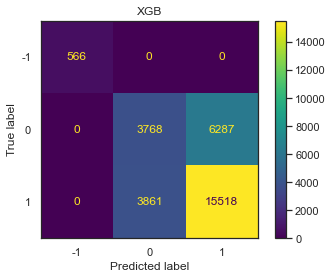

In [53]:
# Confusion matrix
plot_confusion_matrix(xgb, X_test_transformed, y_test)
plt.title('XGB');

#### Light Gradient Boosting

In [54]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
lgb = LGBMClassifier(n_estimators=10000, seed=42)
lgb.fit(X_train_res, y_train_res)

LGBMClassifier(n_estimators=10000, seed=42)

In [55]:
# Score on our training data
y_pred = lgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     45233
           0       1.00      1.00      1.00     45233
           1       1.00      1.00      1.00     45233

    accuracy                           1.00    135699
   macro avg       1.00      1.00      1.00    135699
weighted avg       1.00      1.00      1.00    135699



In [56]:
# Score on testing data
y_pred = lgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       566
           0       0.43      0.37      0.39     10055
           1       0.69      0.74      0.72     19379

    accuracy                           0.62     30000
   macro avg       0.71      0.70      0.70     30000
weighted avg       0.61      0.62      0.61     30000



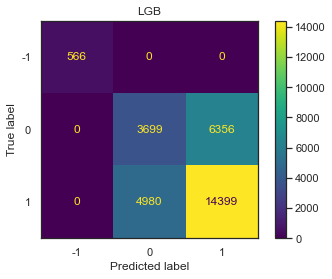

In [57]:
# Confusion matrix
plot_confusion_matrix(lgb, X_test_transformed, y_test)
plt.title('LGB');

#### Neural Networks